In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# initialize threshold/capacity c

c = 4 # in all queues, we make sure that there are no more than c customers at the end of each time interval [t - 1, t]

def elementWiseMin(a1, a2):
    output = np.array([0, 0, 0])
    for i in range(3):
        output[i] = min(a1[i], a2[i])
    return output

def elementWiseMax(a1, a2):
    output = np.array([0, 0, 0])
    for i in range(3):
        output[i] = max(a1[i], a2[i])
    return output

# initialize average arrival rates

a1_avg = 0.3 # average arrival rate for queue 1 (input 1 to output 2)
a2_avg = 0.3 # average arrival rate for queue 2 (input 2 to output 1)
a3_avg = 0.69 # average arrival rate for queue 3 (input 2 to output 2)

def anArrivalVector(a1_avg, a2_avg, a3_avg, seed):
    np.random.seed(seed)
    return np.array([np.random.poisson(a1_avg), np.random.poisson(a2_avg), np.random.poisson(a3_avg)])
    # return np.array([np.random.binomial(n = 100, p = a1_avg / 100), np.random.binomial(n = 100, p = a2_avg / 100), np.random.binomial(n = 100, p = a3_avg / 100)]) 

def chooseEpsilonGreedyServiceConfiguration(s, Q, q, epsilon):
    if np.random.choice(2, p = [epsilon, 1 - epsilon]) == 1: # when we need to use the greedy policy with respect to Q
        if Q[q[0], q[1], q[2], 0] <= Q[q[0], q[1], q[2], 1]:
            s[0] = s[1] = 1
            return
        s[2] = 1
        return
    # when we need to use the random policy
    if np.random.choice(2) == 0:
        s[0] = s[1] = 1
        return
    s[2] = 1

def chooseGreedyServiceConfiguration(s, Q, q):
    if Q[q[0], q[1], q[2], 0] <= Q[q[0], q[1], q[2], 1]:
        s[0] = s[1] = 1
        return
    s[2] = 1

def chooseRandomServiceConfiguration(s):
    if np.random.choice(2) == 0:
        s[0] = s[1] = 1
        return
    s[2] = 1

def chooseMaxWeightServiceConfiguration(s, q):
    if q[0] + q[1] >= q[2]:
        s[0] = s[1] = 1
        return
    s[2] = 1

def chooseEpsilonMaxWeightServiceConfiguration(s, q, epsilon):
    if np.random.choice(2, p = [epsilon, 1 - epsilon]) == 1: # when we need to use the MaxWeight policy
        chooseMaxWeightServiceConfiguration(s, q)
        return
    # when we need to use the random policy
    chooseRandomServiceConfiguration(s)

def chooseMaxSizeCenterConfiguration(s, q):
    if q[2] == 0:
        s[0] = s[1] = 1
        return
    if q[0] == 0 or q[1] == 0:
        s[2] = 1
        return
    s[0] = s[1] = 1

def chooseEpsilonMaxSizeCenterServiceConfiguration(s, q, epsilon):
    if np.random.choice(2, p = [epsilon, 1 - epsilon]) == 1: # when we need to use the MaxSizeCenter policy
        chooseMaxSizeCenterConfiguration(s, q)
        return
    # when we need to use the random policy
    chooseRandomServiceConfiguration(s)

def numberOfZeroValueStateActionPairs(Q):
    output = 0
    for i in range(c + 1):
        for j in range(c + 1):
            for k in range(c + 1):
                for a in range(2):
                    if Q[i, j, k, a] == 0:
                        output += 1
    return output

def steadyStateAverageTotalQueueLengthUsingGreedyPolicy(Q):
    
    # simulate 500,000 times, with q1(0) = q2(0) = q3(0) = 0
    # discard first 100,000 samples to ensure steady state
    
    q1, q2, q3 = np.zeros(int(5e5) + 1), np.zeros(int(5e5) + 1), np.zeros(int(5e5) + 1)
    q1_output, q2_output, q3_output = np.zeros(int(5e5 - 1e5)), np.zeros(int(5e5 - 1e5)), np.zeros(int(5e5 - 1e5))

    for t in range(1, int(5e5) + 1):
        a = anArrivalVector(a1_avg, a2_avg, a3_avg, 2*t)
        s = np.zeros(3)
        chooseGreedyServiceConfiguration(s, Q, np.array([int(q1[t - 1]), int(q2[t - 1]), int(q3[t - 1])]))
        q1[t], q2[t], q3[t] = min(max(q1[t - 1] + a[0] - s[0], 0), c), min(max(q2[t - 1] + a[1] - s[1], 0), c), min(max(q3[t - 1] + a[2] - s[2], 0), c)

        if t > 1e5:
            q1_output[t - int(1e5) - 1], q2_output[t - int(1e5) - 1], q3_output[t - int(1e5) - 1] = q1[t], q2[t], q3[t]

    return np.average(q1_output + q2_output + q3_output)

# Off-policy TD Control for Estimating Optimal Average Total Queue Length

## 1. Differential Q-learning
$\mu_t = \mu_{t - 1} + \eta \alpha \left [r_{t - 1} - \mu_{t - 1} + \displaystyle \min_{\vec s} Q(\vec{q}_{t}, \vec{s}) - Q(\vec{q}_{t - 1}, \vec{s}_{t - 1}) \right]$

$Q(\vec{q}_{t - 1}, \vec{s}_{t - 1}) \leftarrow Q(\vec{q}_{t - 1}, \vec{s}_{t - 1}) + \alpha \left [r_{t - 1} - \mu_{t - 1} + \displaystyle \min_{\vec s} Q(\vec{q}_{t}, \vec{s}) - Q(\vec{q}_{t - 1}, \vec{s}_{t - 1}) \right]$

### i) Behavior Policy: Epsilon-greedy Policy with Respect to Q

### ii) Behavior Policy: Random

In [3]:
# differential q-learning with behavior policy = random

def averageTotalQueueLengthUsingDifferentialQLearning(eta, numOfIterations, alpha):
    
    # initialize current states q, past average reward m, and action-value estimates Q at time t = 0
    
    q = np.array([0, 0, 0])
    m = 0
    Q = np.zeros((c + 1, c + 1, c + 1, 2)) # the first 3 dimensions together represent states q, while the last represents actions s
                                           # the first action is [1, 1, 0], and the second action is [0, 0, 1]
    num_avg = int(0.2 * numOfIterations)
    Q_avg = np.zeros((c + 1, c + 1, c + 1, 2)) # the average Q function over the last num_avg iterations
    t_avg = 1

    # update Q numOfIterations times (with the first one being trivial)

    for t in range(1, numOfIterations + 1):
        # right now we've got q(t - 1)
        s = np.array([0, 0, 0])
        chooseRandomServiceConfiguration(s) # choose service configuration s(t - 1) for the interval [t - 1, t]
        a = anArrivalVector(a1_avg, a2_avg, a3_avg, t) # generate arrival configuration a(t - 1) for the interval [t - 1, t]
        r = sum(q) # compute current reward r(t - 1)
        q_t_minus_1 = q # store q(t - 1)
        q = elementWiseMax(q + a - s, np.array([0, 0, 0]))
        q = elementWiseMin(q, np.array([c, c, c])) # finish computing q(t)
        m_t_minus_1 = m # store m(t - 1)
        
        # compute past average reward m(t) based on t, m(t - 1), current reward r(t - 1), and Q(q(t), .)
        m = m  + eta * alpha * (r - m_t_minus_1 + min(Q[q[0], q[1], q[2], 0], Q[q[0], q[1], q[2], 1]) - Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s[2]])

        # update action-value estimate Q(q(t - 1), s(t - 1)) based on Q(q(t - 1), s(t - 1)), Q(q(t), .), t, r(t - 1), and m(t - 1)
        Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s[2]] += alpha * (r - m_t_minus_1 + min(Q[q[0], q[1], q[2], 0], Q[q[0], q[1], q[2], 1]) - Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s[2]])
        
        if t > numOfIterations - num_avg:
            Q_avg = (1 - 1 / t_avg) * Q_avg + 1 / t_avg * Q
            t_avg += 1
        
    numOfIterationsDividedByOneMillion = int(numOfIterations / 1e6)
    print('For eta = %(eta)s, alpha = %(alpha)s, and numOfIterations = %(numOfIterationsDividedByOneMillion)se6,' % locals())
    print('numberOfZeroValueStateActionPairs =', numberOfZeroValueStateActionPairs(Q_avg), end = ' and ')
    temp = steadyStateAverageTotalQueueLengthUsingGreedyPolicy(Q_avg)
    print('average total queue length \u2248', temp, end = '\n\n')
    return temp

For eta = 0.1, alpha = 0.0005, and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.166635

For eta = 0.1, alpha = 0.001, and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.083155

For eta = 0.1, alpha = 0.005, and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For eta = 0.1, alpha = 0.007, and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For eta = 0.1, alpha = 0.008, and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For eta = 0.1, alpha = 0.009, and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For eta = 0.1, alpha = 0.01, and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For eta = 0.1, alpha = 0.1, and numOfIt

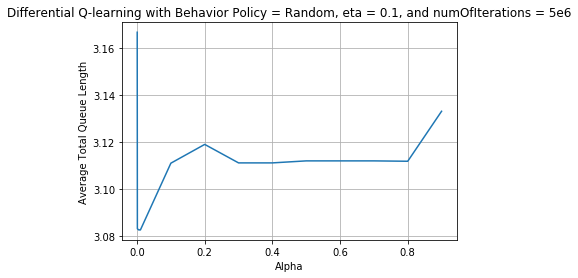

In [4]:
# investigate what alpha values are most effective

eta = 0.1
# eta = np.linspace(0, 2, 21)

numOfIterations = int(5e6)
# numOfIterations = np.array([1000000, 3000000, 6000000, 10000000])

# alpha = 0.1
alpha = np.array([0.0005, 0.001, 0.005, 0.007, 0.008, 0.009, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

avg_total_q = np.zeros(16)
for i in range(16):
    avg_total_q[i] = averageTotalQueueLengthUsingDifferentialQLearning(eta, numOfIterations, alpha[i])

plt.plot(alpha, avg_total_q)
plt.xlabel('Alpha')
plt.ylabel('Average Total Queue Length')
plt.title('Differential Q-learning with Behavior Policy = Random, eta = 0.1, and numOfIterations = 5e6')
plt.grid()
plt.show()

For eta = 0.1, alpha = 0.01, and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For eta = 0.2, alpha = 0.01, and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For eta = 0.3, alpha = 0.01, and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For eta = 0.4, alpha = 0.01, and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For eta = 0.5, alpha = 0.01, and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For eta = 0.6, alpha = 0.01, and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For eta = 0.7, alpha = 0.01, and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For eta = 0.8, alpha = 0.01, and numOfIterations

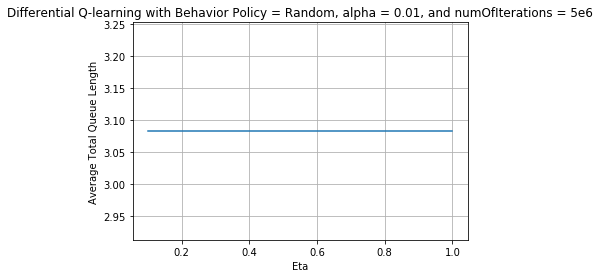

In [5]:
# investigate what eta values are most effective

# eta = 0.1
eta = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

numOfIterations = int(5e6)
# numOfIterations = np.array([1000000, 3000000, 6000000, 10000000])

alpha = 0.01
# alpha = np.array([0.005, 0.007, 0.008, 0.009, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

avg_total_q = np.zeros(10)
for i in range(10):
    avg_total_q[i] = averageTotalQueueLengthUsingDifferentialQLearning(eta[i], numOfIterations, alpha)

plt.plot(eta, avg_total_q)
plt.xlabel('Eta')
plt.ylabel('Average Total Queue Length')
plt.title('Differential Q-learning with Behavior Policy = Random, alpha = 0.01, and numOfIterations = 5e6')
plt.grid()
plt.show()

### iii) Behavior Policy: Epsilon-MaxWeight

### iv) Behavior Policy: Epsilon-MSC


## 2. Relative-value-iteration (RVI) Q-learning
$Q(\vec{q}_{t - 1}, \vec{s}_{t - 1}) \leftarrow Q(\vec{q}_{t - 1}, \vec{s}_{t - 1}) + \alpha \left [r_{t - 1} + \displaystyle \min_{\vec s} Q(\vec{q}_{t}, \vec{s}) - f(Q) - Q(\vec{q}_{t - 1}, \vec{s}_{t - 1}) \right]$
### (Behavior Policy: Random)

In [6]:
# relative-value-iteration q-learning with behavior policy = random

def averageTotalQueueLengthUsingRVIQLearning(f, numOfIterations, alpha):

    # initialize current states q and action-value estimates Q at time t = 0

    q = np.array([0, 0, 0])
    Q = np.zeros((c + 1, c + 1, c + 1, 2)) # the first 3 dimensions together represent states q, while the last represents actions s
                                           # the first action is [1, 1, 0], and the second action is [0, 0, 1]
    num_avg = int(0.2 * numOfIterations)
    Q_avg = np.zeros((c + 1, c + 1, c + 1, 2)) # the average Q function over the last num_avg iterations
    t_avg = 1

    # update Q numOfIterations times (with the first one being trivial)

    for t in range(1, numOfIterations + 1):
        # right now we've got q(t - 1)
        s = np.array([0, 0, 0])
        chooseRandomServiceConfiguration(s) # choose service configuration s(t - 1) for the interval [t - 1, t]
        a = anArrivalVector(a1_avg, a2_avg, a3_avg, t) # generate arrival configuration a(t - 1) for the interval [t - 1, t]
        r = sum(q) # compute current reward r(t - 1)
        q_t_minus_1 = q # store q(t - 1)
        q = elementWiseMin(elementWiseMax(q + a - s, np.array([0, 0, 0])), np.array([c, c, c]))

        # update action-value estimate Q(q(t - 1), s(t - 1)) based on Q(q(t), .), t, r(t - 1), and Q(q(t - 1), s(t - 1))
        Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s[2]] += alpha * (r + min(Q[q[0], q[1], q[2], 0], Q[q[0], q[1], q[2], 1]) - f(Q) - Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s[2]])
    
        if t > numOfIterations - num_avg:
                Q_avg = (1 - 1 / t_avg) * Q_avg + 1 / t_avg * Q
                t_avg += 1
    
    numOfIterationsDividedByOneMillion = int(numOfIterations / 1e6)
    print('For alpha = %(alpha)s and numOfIterations = %(numOfIterationsDividedByOneMillion)se6,' % locals())
    print('numberOfZeroValueStateActionPairs =', numberOfZeroValueStateActionPairs(Q_avg), end = ' and ')
    temp = steadyStateAverageTotalQueueLengthUsingGreedyPolicy(Q_avg)
    print('average total queue length \u2248', temp, end = '\n\n')
    return temp

### i) $f(Q) = \displaystyle \frac{1}{2(c + 1) ^ 3}\sum_{\vec{q},\ \vec{s}} Q(\vec{q}, \vec{s})$
#### where c = capacity/threshold

In [7]:
def f(Q):
    return (1 / (2 * (c + 1) ** 3)) * np.sum(Q)

For alpha = 0.0005 and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.2349

For alpha = 0.001 and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.0847275

For alpha = 0.005 and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For alpha = 0.007 and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For alpha = 0.008 and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For alpha = 0.009 and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For alpha = 0.01 and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08264

For alpha = 0.1 and numOfIterations = 5e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.1189875


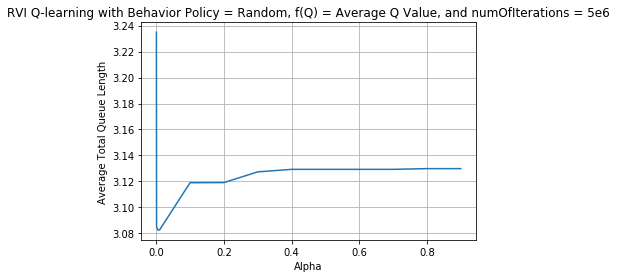

In [8]:
# investigate what alpha values are most effective

numOfIterations = int(5e6)
# numOfIterations = np.array([1000000, 3000000, 6000000, 10000000])

# alpha = 0.01
alpha = np.array([0.0005, 0.001, 0.005, 0.007, 0.008, 0.009, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

avg_total_q = np.zeros(16)
for i in range(16):
    avg_total_q[i] = averageTotalQueueLengthUsingRVIQLearning(f, numOfIterations, alpha[i])

plt.plot(alpha, avg_total_q)
plt.xlabel('Alpha')
plt.ylabel('Average Total Queue Length')
plt.title('RVI Q-learning with Behavior Policy = Random, f(Q) = Average Q Value, and numOfIterations = 5e6')
plt.grid()
plt.show()

### ii) $f(Q) = \displaystyle Q \left(\begin{bmatrix} 0\\ 0\\ 0 \end{bmatrix}, \begin{bmatrix} 1\\ 1\\ 0 \end{bmatrix} \right)$

In [ ]:
def f(Q):
    return Q[0, 0, 0, 0]

### iii) $f(Q) = \displaystyle \min_{\vec{s}} Q \left(\begin{bmatrix} 0\\ 0\\ 0 \end{bmatrix}, \vec{s} \right)$

In [ ]:
def f(Q):
    return min(Q[0, 0, 0, 0], Q[0, 0, 0, 1])

## 3. Discounted-cost Q-learning

$Q(\vec{q}_{t - 1}, \vec{s}_{t - 1}) \leftarrow Q(\vec{q}_{t - 1}, \vec{s}_{t - 1}) + \alpha\left [r_{t - 1} + \gamma \displaystyle \min_{\vec s} Q(\vec{q}_t, \vec{s}) - Q(\vec{q}_{t - 1}, \vec{s}_{t - 1}) \right]$

### i) Behavior Policy: Epsilon-greedy with Respect to Q

### ii) Behavior Policy: Random

In [9]:
# discounted-cost q-learning with behavior policy = random

def averageTotalQueueLengthUsingDiscountedCostQLearning(gamma, numOfIterations, alpha):

    # initialize current states q and action-value estimates Q at time t = 0

    q = np.array([0, 0, 0])
    Q = np.zeros((c + 1, c + 1, c + 1, 2)) # the first 3 dimensions together represent states q, while the last represents actions s
                                           # the first action is [1, 1, 0], and the second action is [0, 0, 1]
    num_avg = int(0.2 * numOfIterations)
    Q_avg = np.zeros((c + 1, c + 1, c + 1, 2)) # the average Q function over the last num_avg iterations
    t_avg = 1

    # update Q numOfIterations times (with the first one being trivial)

    for t in range(1, numOfIterations + 1):
        # right now we've got q(t - 1)
        s = np.array([0, 0, 0])
        chooseRandomServiceConfiguration(s) # choose service configuration s(t - 1) for the interval [t - 1, t]
        a = anArrivalVector(a1_avg, a2_avg, a3_avg, t) # generate arrival configuration a(t - 1) for the interval [t - 1, t]
        r = sum(q) # compute current reward r(t - 1)
        q_t_minus_1 = q # store q(t - 1)
        q = elementWiseMin(elementWiseMax(q + a - s, np.array([0, 0, 0])), np.array([c, c, c]))

        # update action-value estimate Q(q(t - 1), s(t - 1)) based on Q(q(t), .), t, r(t - 1), and Q(q(t - 1), s(t - 1))
        Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s[2]] += alpha * (r + gamma * min(Q[q[0], q[1], q[2], 0], Q[q[0], q[1], q[2], 1]) - Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s[2]])
    
        if t > numOfIterations - num_avg:
                Q_avg = (1 - 1 / t_avg) * Q_avg + 1 / t_avg * Q
                t_avg += 1
    
    numOfIterationsDividedByOneMillion = int(numOfIterations / 1e6)
    print('For gamma = %(gamma)s, alpha = %(alpha)s, and numOfIterations = %(numOfIterationsDividedByOneMillion)se6,' % locals())
    print('numberOfZeroValueStateActionPairs =', numberOfZeroValueStateActionPairs(Q_avg), end = ' and ')
    temp = steadyStateAverageTotalQueueLengthUsingGreedyPolicy(Q_avg)
    print('average total queue length \u2248', temp, end = '\n\n')
    return temp

For gamma = 0.99, alpha = 0.0055, and numOfIterations = 20e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.173185

For gamma = 0.99, alpha = 0.007, and numOfIterations = 20e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.0822125

For gamma = 0.99, alpha = 0.008, and numOfIterations = 20e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.0825725

For gamma = 0.99, alpha = 0.009, and numOfIterations = 20e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.0825725

For gamma = 0.99, alpha = 0.01, and numOfIterations = 20e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.0825725

For gamma = 0.99, alpha = 0.1, and numOfIterations = 20e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.110865

For gamma = 0.99, alpha = 0.2, and numOfIterations = 20e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.110705

For ga

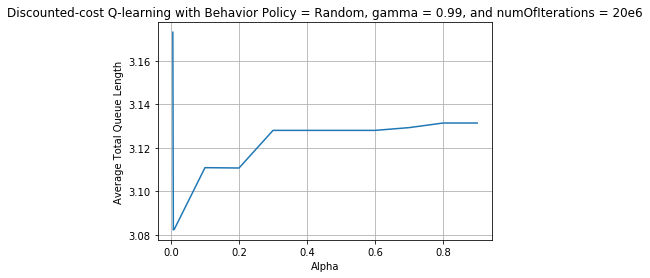

In [10]:
# investigate what alpha values are most effective

gamma = 0.99
# gamma = np.linspace(0, 1, 21)

numOfIterations = int(20e6)
# numOfIterations = np.array([1000000, 3000000, 6000000, 10000000])

# alpha = 0.01
alpha = np.array([0.0055, 0.007, 0.008, 0.009, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

avg_total_q = np.zeros(14)
for i in range(14):
    avg_total_q[i] = averageTotalQueueLengthUsingDiscountedCostQLearning(gamma, numOfIterations, alpha[i])

plt.plot(alpha, avg_total_q)
plt.xlabel('Alpha')
plt.ylabel('Average Total Queue Length')
plt.title('Discounted-cost Q-learning with Behavior Policy = Random, gamma = 0.99, and numOfIterations = 20e6')
plt.grid()
plt.show()

For gamma = 0.1, alpha = 0.01, and numOfIterations = 20e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.18689

For gamma = 0.2, alpha = 0.01, and numOfIterations = 20e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.1428075

For gamma = 0.3, alpha = 0.01, and numOfIterations = 20e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.1428075

For gamma = 0.4, alpha = 0.01, and numOfIterations = 20e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.14274

For gamma = 0.5, alpha = 0.01, and numOfIterations = 20e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.14274

For gamma = 0.6, alpha = 0.01, and numOfIterations = 20e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.14274

For gamma = 0.7, alpha = 0.01, and numOfIterations = 20e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.14274

For gamma = 0.75, alpha

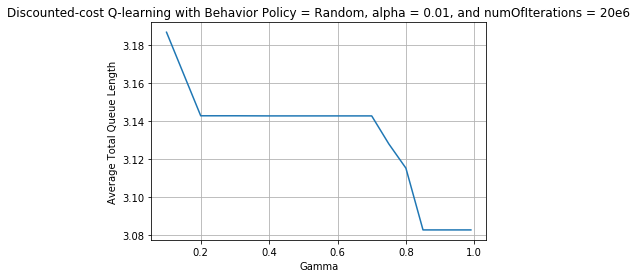

In [11]:
# investigate what gamma values are most effective

# gamma = 0.99
gamma = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

numOfIterations = int(20e6)
# numOfIterations = np.array([1000000, 3000000, 6000000, 10000000])

alpha = 0.01
# alpha = np.linspace(0.001, 0.01, 10)

avg_total_q = np.zeros(20)
for i in range(20):
    avg_total_q[i] = averageTotalQueueLengthUsingDiscountedCostQLearning(gamma[i], numOfIterations, alpha)

plt.plot(gamma, avg_total_q)
plt.xlabel('Gamma')
plt.ylabel('Average Total Queue Length')
plt.title('Discounted-cost Q-learning with Behavior Policy = Random, alpha = 0.01, and numOfIterations = 20e6')
plt.grid()
plt.show()

### iii) Behavior Policy: Epsilon-MaxWeight

### iv) Behavior Policy: Epsilon-MSC

## 4. Average-cost Q-learning
$\mu_t = \displaystyle (1 - \frac{1}{t}) \mu_{t - 1} + \frac{1}{t}r_{t - 1}$

$Q(\vec{q}_{t - 1}, \vec{s}_{t - 1}) \leftarrow Q(\vec{q}_{t - 1}, \vec{s}_{t - 1}) + \alpha \left [r_{t - 1} - \mu_{t - 1} + \displaystyle \min_{\vec s} Q(\vec{q}_{t}, \vec{s}) - Q(\vec{q}_{t - 1}, \vec{s}_{t - 1}) \right]$

### i) Behavior Policy: Epsilon-greedy Policy with Respect to Q

In [12]:
# average-cost q-learning with behavior policy = epsilon-greedy

def averageTotalQueueLengthUsingAverageCostQLearning(epsilon, numOfIterations, alpha):
    
    # initialize current states q, past average reward m, and action-value estimates Q at time t = 0
    
    q = np.array([0, 0, 0])
    m = 0
    Q = np.zeros((c + 1, c + 1, c + 1, 2)) # the first 3 dimensions together represent states q, while the last represents actions s
                                           # the first action is [1, 1, 0], and the second action is [0, 0, 1]
    num_avg = int(0.2 * numOfIterations)
    Q_avg = np.zeros((c + 1, c + 1, c + 1, 2)) # the average Q function over the last num_avg iterations
    t_avg = 1

    # update Q numOfIterations times (with the first one being trivial)

    for t in range(1, numOfIterations + 1):
        # right now we've got q(t - 1)
        s = np.array([0, 0, 0])
        chooseEpsilonGreedyServiceConfiguration(s, Q, q, epsilon) # choose service configuration s(t - 1) for the interval [t - 1, t]
        a = anArrivalVector(a1_avg, a2_avg, a3_avg, t) # generate arrival configuration a(t - 1) for the interval [t - 1, t]
        r = sum(q) # compute current reward r(t - 1)
        
        m_t_minus_1 = m # store m(t - 1)
        # compute past average reward m(t) based on t, m(t - 1), current reward r(t - 1)
        m = (1 - 1 / t) * m + (1 / t) * r
        
        q_t_minus_1 = q # store q(t - 1)
        q = elementWiseMax(q + a - s, np.array([0, 0, 0]))
        q = elementWiseMin(q, np.array([c, c, c])) # finish computing q(t)

        # update action-value estimate Q(q(t - 1), s(t - 1)) based on Q(q(t - 1), s(t - 1)), Q(q(t), .), t, r(t - 1), and m(t - 1)
        Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s[2]] += alpha * (r - m_t_minus_1 + min(Q[q[0], q[1], q[2], 0], Q[q[0], q[1], q[2], 1]) - Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s[2]])
        
        if t > numOfIterations - num_avg:
            Q_avg = (1 - 1 / t_avg) * Q_avg + 1 / t_avg * Q
            t_avg += 1

    print('For epsilon = %(epsilon)s, alpha = %(alpha)s, and numOfIterations = %(numOfIterations)s,' % locals())
    print('numberOfZeroValueStateActionPairs =', numberOfZeroValueStateActionPairs(Q_avg), end = ' and ')
    temp = steadyStateAverageTotalQueueLengthUsingGreedyPolicy(Q_avg)
    print('average total queue length \u2248', temp, end = '\n\n')
    return temp

For epsilon = 0.1, alpha = 0.0003, and numOfIterations = 20000000,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 6.6072

For epsilon = 0.1, alpha = 0.0005, and numOfIterations = 20000000,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.151375

For epsilon = 0.1, alpha = 0.001, and numOfIterations = 20000000,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.1562125

For epsilon = 0.1, alpha = 0.005, and numOfIterations = 20000000,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.144375

For epsilon = 0.1, alpha = 0.007, and numOfIterations = 20000000,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.145575

For epsilon = 0.1, alpha = 0.008, and numOfIterations = 20000000,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.144375

For epsilon = 0.1, alpha = 0.009, and numOfIterations = 20000000,
numberOfZeroValueStateActionPairs = 0 and average t

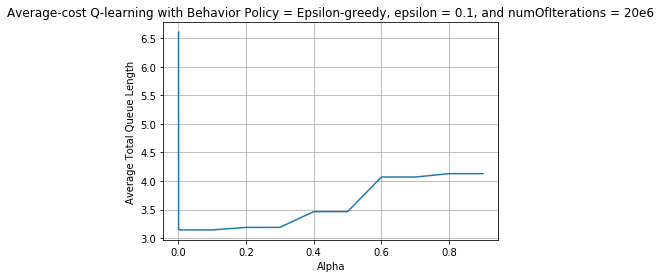

In [13]:
# investigate what alpha values are most effective

epsilon = 0.1
# epsilon = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

numOfIterations = int(20e6)
# numOfIterations = np.array([1000000, 3000000, 6000000, 10000000])

# alpha = 0.01
alpha = np.array([0.0003, 0.0005, 0.001, 0.005, 0.007, 0.008, 0.009, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

avg_total_q = np.zeros(17)
for i in range(17):
    avg_total_q[i] = averageTotalQueueLengthUsingAverageCostQLearning(epsilon, numOfIterations, alpha[i])

plt.plot(alpha, avg_total_q)
plt.xlabel('Alpha')
plt.ylabel('Average Total Queue Length')
plt.title('Average-cost Q-learning with Behavior Policy = Epsilon-greedy, epsilon = 0.1, and numOfIterations = 20e6')
plt.grid()
plt.show()

For epsilon = 0.1, alpha = 0.01, and numOfIterations = 20000000,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.1428275

For epsilon = 0.2, alpha = 0.01, and numOfIterations = 20000000,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.1428275

For epsilon = 0.3, alpha = 0.01, and numOfIterations = 20000000,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.1869475

For epsilon = 0.4, alpha = 0.01, and numOfIterations = 20000000,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.1869475

For epsilon = 0.5, alpha = 0.01, and numOfIterations = 20000000,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.1869475

For epsilon = 0.6, alpha = 0.01, and numOfIterations = 20000000,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.1869475

For epsilon = 0.7, alpha = 0.01, and numOfIterations = 20000000,
numberOfZeroValueStateActionPairs = 0 and average tot

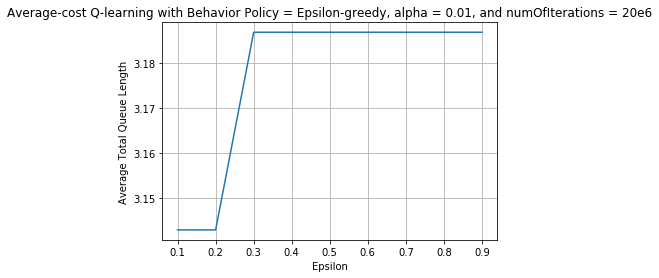

In [14]:
# investigate what epsilon values are most effective

# epsilon = 0.1
epsilon = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

numOfIterations = int(20e6)
# numOfIterations = np.array([1000000, 3000000, 6000000, 10000000])

alpha = 0.01
# alpha = np.array([0.005, 0.007, 0.008, 0.009, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

avg_total_q = np.zeros(9)
for i in range(9):
    avg_total_q[i] = averageTotalQueueLengthUsingAverageCostQLearning(epsilon[i], numOfIterations, alpha)

plt.plot(epsilon, avg_total_q)
plt.xlabel('Epsilon')
plt.ylabel('Average Total Queue Length')
plt.title('Average-cost Q-learning with Behavior Policy = Epsilon-greedy, alpha = 0.01, and numOfIterations = 20e6')
plt.grid()
plt.show()

### ii) Behavior Policy: Random

### iii) Behavior Policy: Epsilon-MaxWeight

### iv) Behavior Policy: Epsilon-MSC

# On-policy TD Control for Estimating Optimal Average Total Queue Length
## (Average-cost Sarsa)
$Q(\vec{q}_{t - 1}, \vec{s}_{t - 1}) \leftarrow Q(\vec{q}_{t - 1}, \vec{s}_{t - 1}) + \frac{1}{t}\left [r_{t - 1} - \mu_{t - 1} + Q(\vec{q}_{t}, \vec{s}_{t}) - Q(\vec{q}_{t - 1}, \vec{s}_{t - 1}) \right]$

In [15]:
def averageTotalQueueLengthUsingAverageCostSarsa(epsilon, numOfIterations, alpha):
    
    # initialize current states q, past average reward m, and action-value estimates Q at time t = 0

    q = np.array([0, 0, 0])
    m = 0
    Q = np.zeros((c + 1, c + 1, c + 1, 2)) # the first 3 dimensions together represent states q, while the last represents actions s
                                           # the first action is [1, 1, 0], and the second action is [0, 0, 1]
    num_avg = int(0.2 * numOfIterations)
    Q_avg = np.zeros((c + 1, c + 1, c + 1, 2)) # the average Q function over the last num_avg iterations
    t_avg = 1

    # choose action (service configuration) s at time t = 0
    s = np.array([0, 0, 0])
    chooseEpsilonGreedyServiceConfiguration(s, Q, q, epsilon) # determine s(0)

    # update Q 10,000,000 times (with the first one being trivial)

    for t in range(1, numOfIterations + 1):
        # right now we've got q(t - 1), s(t - 1), and m(t - 1)
        a = anArrivalVector(a1_avg, a2_avg, a3_avg, t) # generate arrival configuration a(t - 1) for the interval [t - 1, t]
        r = sum(q) # compute current reward r(t - 1)
        m_t_minus_1 = m # store m(t - 1)
        m = (1 - 1 / t) * m  + 1 / t * r # compute past average reward m(t) based on t, m(t - 1), and current reward r(t - 1)
        q_t_minus_1 = q # store q(t - 1)
        q = elementWiseMax(q + a - s, np.array([0, 0, 0]))
        q = elementWiseMin(q, np.array([c, c, c])) # finish computing q(t)
        s_t_minus_1 = s # store s(t - 1)
        s = np.array([0, 0, 0])
        chooseEpsilonGreedyServiceConfiguration(s, Q, q, epsilon) # determine s(t)

        # update action-value estimate Q(q(t - 1), s(t - 1)) based on Q(q(t - 1), s(t - 1)), t, r(t - 1), m(t - 1), and Q(q(t), s(t))
        Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s_t_minus_1[2]] += alpha * (r - m_t_minus_1 + Q[q[0], q[1], q[2], s[2]] - Q[q_t_minus_1[0], q_t_minus_1[1], q_t_minus_1[2], s_t_minus_1[2]])
    
        if t > numOfIterations - num_avg:
                Q_avg = (1 - 1 / t_avg) * Q_avg + 1 / t_avg * Q
                t_avg += 1
    
    numOfIterationsDividedByOneMillion = int(numOfIterations / 1e6)
    print('For epsilon = %(epsilon)s, alpha = %(alpha)s, and numOfIterations = %(numOfIterationsDividedByOneMillion)se6,' % locals())
    print('numberOfZeroValueStateActionPairs =', numberOfZeroValueStateActionPairs(Q_avg), end = ' and ')
    temp = steadyStateAverageTotalQueueLengthUsingGreedyPolicy(Q_avg)
    print('average total queue length \u2248', temp, end = '\n\n')
    return temp

For epsilon = 0.1, alpha = 2e-05, and numOfIterations = 100e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.22462

For epsilon = 0.1, alpha = 5e-05, and numOfIterations = 100e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.1700175

For epsilon = 0.1, alpha = 0.0001, and numOfIterations = 100e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.1430175

For epsilon = 0.1, alpha = 0.0005, and numOfIterations = 100e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.083155

For epsilon = 0.1, alpha = 0.001, and numOfIterations = 100e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.083155

For epsilon = 0.1, alpha = 0.005, and numOfIterations = 100e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.0825725

For epsilon = 0.1, alpha = 0.007, and numOfIterations = 100e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length 

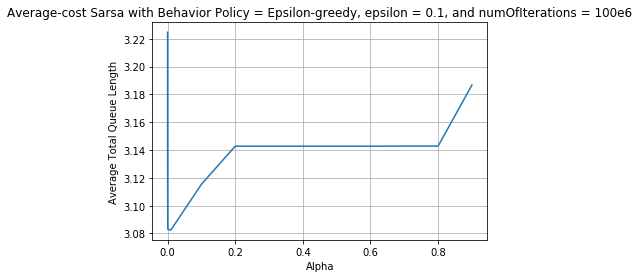

In [16]:
# investigate what alpha values are most effective

epsilon = 0.1

numOfIterations = int(100e6)

# alpha = 0.01
alpha = np.array([0.00002, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.007, 0.01, 0.1, 0.2, 0.3, 0.6, 0.7, 0.8, 0.9])

avg_total_q = np.zeros(15)
for i in range(15):
    avg_total_q[i] = averageTotalQueueLengthUsingAverageCostSarsa(epsilon, numOfIterations, alpha[i])

plt.plot(alpha, avg_total_q)
plt.xlabel('Alpha')
plt.ylabel('Average Total Queue Length')
plt.title('Average-cost Sarsa with Behavior Policy = Epsilon-greedy, epsilon = 0.1, and numOfIterations = 100e6')
plt.grid()
plt.show()

For epsilon = 0.1, alpha = 0.01, and numOfIterations = 100e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.0825725

For epsilon = 0.2, alpha = 0.01, and numOfIterations = 100e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.0825725

For epsilon = 0.3, alpha = 0.01, and numOfIterations = 100e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.0825725

For epsilon = 0.4, alpha = 0.01, and numOfIterations = 100e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.0825725

For epsilon = 0.5, alpha = 0.01, and numOfIterations = 100e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.0825725

For epsilon = 0.6, alpha = 0.01, and numOfIterations = 100e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.082815

For epsilon = 0.7, alpha = 0.01, and numOfIterations = 100e6,
numberOfZeroValueStateActionPairs = 0 and average total queue length ≈ 3.08

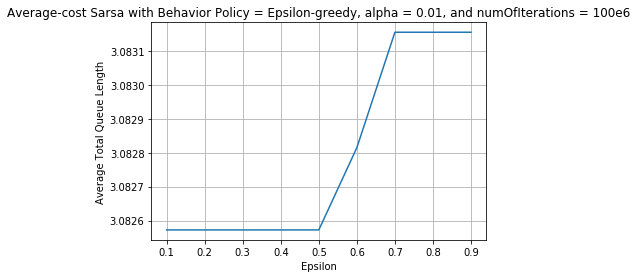

In [17]:
# investigate what epsilon values are most effective

# epsilon = 0.1
epsilon = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

numOfIterations = int(100e6)

alpha = 0.01

avg_total_q = np.zeros(9)
for i in range(9):
    avg_total_q[i] = averageTotalQueueLengthUsingAverageCostSarsa(epsilon[i], numOfIterations, alpha)

plt.plot(epsilon, avg_total_q)
plt.xlabel('Epsilon')
plt.ylabel('Average Total Queue Length')
plt.title('Average-cost Sarsa with Behavior Policy = Epsilon-greedy, alpha = 0.01, and numOfIterations = 100e6')
plt.grid()
plt.show()

# Average Total Queue Length Using Random Policy

In [18]:
# random policy:
# during each interval [t - 1, t], choose a random configuration

# simulate 500,000 times, with q1(0) = q2(0) = q3(0) = 0
# discard first 100,000 samples to ensure steady state

q1, q2, q3 = np.zeros(int(5e5 + 1)), np.zeros(int(5e5 + 1)), np.zeros(int(5e5 + 1))
q1_output, q2_output, q3_output = np.zeros(int(5e5 - 1e5)), np.zeros(int(5e5 - 1e5)), np.zeros(int(5e5 - 1e5))

for t in range(1, int(5e5 + 1)):
    a = anArrivalVector(a1_avg, a2_avg, a3_avg, 2*t)
    s = np.zeros(3)
    chooseRandomServiceConfiguration(s)
    q1[t], q2[t], q3[t] = min(max(q1[t - 1] + a[0] - s[0], 0), c), min(max(q2[t - 1] + a[1] - s[1], 0), c), min(max(q3[t - 1] + a[2] - s[2], 0), c)

    if t > 1e5:
        q1_output[t - int(1e5) - 1], q2_output[t - int(1e5) - 1], q3_output[t - int(1e5) - 1] = q1[t], q2[t], q3[t]

# output

print('Random Policy Gives')
print('Average Total Queue Length \u2248', np.average(q1_output + q2_output + q3_output))

Random Policy Gives
Average Total Queue Length ≈ 4.3633425


# Average Total Queue Length Using MaxWeight Policy

In [19]:
# MaxWeight policy:
# during each interval [t - 1, t], choose a configuration such that the queues being served have the maximum combined size

# simulate 500,000 times, with q1(0) = q2(0) = q3(0) = 0
# discard first 100,000 samples to ensure steady state

q1, q2, q3 = np.zeros(int(5e5 + 1)), np.zeros(int(5e5 + 1)), np.zeros(int(5e5 + 1))
q1_output, q2_output, q3_output = np.zeros(int(5e5 - 1e5)), np.zeros(int(5e5 - 1e5)), np.zeros(int(5e5 - 1e5))

for t in range(1, int(5e5 + 1)):
    a = anArrivalVector(a1_avg, a2_avg, a3_avg, 2*t)
    s = np.zeros(3)
    chooseMaxWeightServiceConfiguration(s, np.array([int(q1[t - 1]), int(q2[t - 1]), int(q3[t - 1])]))
    q1[t], q2[t], q3[t] = min(max(q1[t - 1] + a[0] - s[0], 0), c), min(max(q2[t - 1] + a[1] - s[1], 0), c), min(max(q3[t - 1] + a[2] - s[2], 0), c)

    if t > 1e5:
        q1_output[t - int(1e5) - 1], q2_output[t - int(1e5) - 1], q3_output[t - int(1e5) - 1] = q1[t], q2[t], q3[t]

# output

print('MaxWeight Policy Gives')
print('Average Total Queue Length \u2248', np.average(q1_output + q2_output + q3_output))

MaxWeight Policy Gives
Average Total Queue Length ≈ 4.1297025


# Average Total Queue Length Using MSC Policy

In [20]:
# MaxSizeCenter policy:
# during each interval [t - 1, t], choose a configuration that serves the first two queues unless both of them are empty and the third one is not

# simulate 500,000 times, with q1(0) = q2(0) = q3(0) = 0
# discard first 100,000 samples to ensure steady state

q1, q2, q3 = np.zeros(int(5e5 + 1)), np.zeros(int(5e5 + 1)), np.zeros(int(5e5 + 1))
q1_output, q2_output, q3_output = np.zeros(int(5e5 - 1e5)), np.zeros(int(5e5 - 1e5)), np.zeros(int(5e5 - 1e5))

for t in range(1, int(5e5 + 1)):
    a = anArrivalVector(a1_avg, a2_avg, a3_avg, 2*t)
    s = np.zeros(3)
    chooseMaxSizeCenterConfiguration(s, np.array([int(q1[t - 1]), int(q2[t - 1]), int(q3[t - 1])]))
    q1[t], q2[t], q3[t] = min(max(q1[t - 1] + a[0] - s[0], 0), c), min(max(q2[t - 1] + a[1] - s[1], 0), c), min(max(q3[t - 1] + a[2] - s[2], 0), c)

    if t > 1e5:
        q1_output[t - int(1e5) - 1], q2_output[t - int(1e5) - 1], q3_output[t - int(1e5) - 1] = q1[t], q2[t], q3[t]

# output

print('MaxSizeCenter Policy Gives')
print('Average Total Queue Length \u2248', np.average(q1_output + q2_output + q3_output))

MaxSizeCenter Policy Gives
Average Total Queue Length ≈ 3.75844
